In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from models import build_model
from dataset import get_train_and_validation_dataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cpu


# shapes

# Data exploration

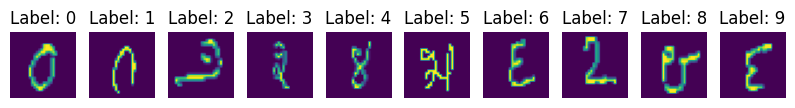

In [2]:
data_df = pd.read_csv("data/train.csv")
X_data = data_df.values[:,1:]
y_data = data_df.values[:,0]

data_df_test = pd.read_csv("data/test.csv")
X_test = data_df_test.values[:,1:]

num_images = 10
fig, ax = plt.subplots(1,num_images, figsize=(10, 1))


for idx in range(0,num_images):
    ax[idx].axis('off')
    ax[idx].imshow(X_data[idx].reshape(28,28))
    ax[idx].set_title(f"Label: {y_data[idx]}")


### Is the dataset balanced?

- there are an equal number of each digit in the data

In [40]:
64*2

128

In [3]:

print(np.unique(y_data, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


## Are there any duplicates?

- There are no duplicates images in the training and validation dataset

In [4]:
def has_duplicates(X):
    _, num_unique_counts = np.unique(X, axis=0, return_counts=True)
    return np.all(num_unique_counts!=1)

print(f"Training data has duplicates: {has_duplicates(X_data)}")

print(f"Testing data has duplicates: {has_duplicates(X_test)}")


Training data has duplicates: False
Testing data has duplicates: False


# Train

In [31]:
trainloader, valloader, testloader = get_train_and_validation_dataset(
                                batch_size=64, 
                                proportion_train=0.8, 
                                )


model = build_model()
model.to(device)

# learning_rate = 1e-2 # MLP
learning_rate = 5e-3 # CNN


optimiser = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(16, 4, kernel_

In [32]:
# classes = range(10)

# imgs, lbls = next(iter(trainloader))
# imgs[7].data.shape
# print(imgs.data.min())
# print(imgs.data.max())
# print(imgs.data.mean())
# print(imgs.data.std())
# print(classes[lbls[0]])
# plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [33]:

def train_epoch(epoch):
    model.train()
    for b_idx, (X_batch, y_batch) in enumerate(trainloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
#         optimiser.zero_grad()
#         log_probs = model(X_batch)
#         loss = criterion(log_probs, y_batch)
#         loss.backward()
#         optimiser.step()
#         pred = log_probs.data.max(1, keepdim=True)[1]
#         correct = pred.eq(y_batch.data.view_as(pred)).sum()
    print("done")
#     print(f"----\nEpoch {epoch}: training loss={loss.item():.4f}")

def validate():
    model.eval()
    validate_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in valloader:
            X = X.to(device)
            y = y.to(device)
            log_probs = model(X)
            validate_loss += criterion(log_probs, y).item()
            pred = log_probs.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum()
    validate_loss /= len(valloader.dataset)
    
    print(f"Validation: loss={validate_loss:.6f}, accuracy={correct/len(X):.4f}%")
    return validate_loss


In [34]:
import time

In [35]:
%%time

num_epochs = 1
print(f"Training Kannada-MNIST for {num_epochs} epochs\n")

for epoch in range(1, num_epochs+1):
    train_epoch(epoch)
    _ = validate()
print("Done.")


Training Kannada-MNIST for 1 epochs

done
train time: 10.893sec
Validation: loss=0.000192, accuracy=0.1000%
val time: 2.935sec
Done.
CPU times: user 13.8 s, sys: 655 ms, total: 14.5 s
Wall time: 13.8 s


In [9]:
X_test, _ = next(iter(testloader))
X_test = X_test.to(device)
test_preds = model(X_test).data.max(dim=1)[1].detach().cpu().numpy()

test_preds_df = pd.DataFrame(np.stack([np.arange(len(test_preds)), np.array(test_preds)]).T, 
                             columns=['id', 'label'])

test_preds_df.to_csv("submission.csv", index=False)

test_preds_df.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


## Grid search

In [10]:
# dt_grid = [1e-4, 1e-3, 1e-2]
# batch_size_grid = [8, 32, 64]


# for dt in dt_grid:
#     for batch_size in batch_size_grid:
#         print(f"\n======\nGridsearch for dt, batch_size = ({dt}, {batch_size})")
        